Actor Critic with OpenAI Gym

http://www.rage.net/~greg/2016-07-05-ActorCritic-with-OpenAI-Gym.html

In [9]:
%pylab inline

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

from IPython.display import clear_output
import time
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop, SGD

Populating the interactive namespace from numpy and matplotlib


Environment: 'Frozen Lake' of a version which does not include slippery ice. 

In [2]:
# Create a non-skid version of Frozen Lake

from gym.envs.registration import register, spec

MY_ENV_NAME = 'FrozenLakeNonskid8x8-v0'

try:
    spec(MY_ENV_NAME)
except:
    register(
        id = MY_ENV_NAME,
        entry_point = 'gym.envs.toy_text:FrozenLakeEnv',
        kwargs = {'map_name': '8x8', 'is_slippery': False},
        timestep_limit = 100,
        reward_threshold=0.78,  # optimum = 0.8196
    )
    
env = gym.make(MY_ENV_NAME)

[2017-12-18 20:55:38,558] Making new env: FrozenLakeNonskid8x8-v0


In [3]:
# helpers

def to_onehot(size, value):
    onehot = np.zeros((size))
    onehot[value] = 1.0
    return onehot

OBSERVATION_SPACE = env.observation_space.n
ACTION_SPACE = env.action_space.n

In [6]:
# Actor

actor = Sequential()

actor.add(Dense(164, kernel_initializer='lecun_uniform', input_shape=(OBSERVATION_SPACE,)))
actor.add(Activation('relu'))

actor.add(Dense(150, kernel_initializer='lecun_uniform'))
actor.add(Activation('relu'))

actor.add(Dense(ACTION_SPACE, kernel_initializer='lecun_uniform'))
actor.add(Activation('linear'))

actor_optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
actor.compile(loss='mse', optimizer=actor_optimizer)

In [8]:
# critic

critic = Sequential()

critic.add(Dense(164, kernel_initializer='lecun_uniform', input_shape=(OBSERVATION_SPACE,)))
critic.add(Activation('relu'))

critic.add(Dense(150, kernel_initializer='lecun_uniform'))
critic.add(Activation('relu'))

critic.add(Dense(1, kernel_initializer='lecun_uniform'))
critic.add(Activation('linear'))

critic_optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
critic.compile(loss='mse', optimizer=critic_optimizer)

In [38]:
# Plot out the critic's estimation of state value.

def plot_value(initial_state):
    # record current value on this grid.
    values_grid = np.zeros(initial_state.shape)
    
    for x in range(grid_size):
        for y in range(grid_size):
            grid = initial_state.copy()
            grid[x,y] = 1  # agent position
            value = critic.predict(grid.reshape(1, OBSERVATION_SPACE))
            values_grid[x,y] = value
            
    pylab.pcolor(values_grid)
    pylab.title("Estimated Values")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()

In [34]:
GRID_SIZE = np.sqrt(OBSERVATION_SPACE).astype(np.int64)
TEST_GRID = np.zeros((GRID_SIZE, GRID_SIZE))


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
(1, 1)


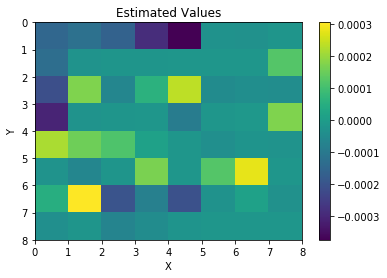

In [39]:
env.reset()
env.render()

plot_value(TEST_GRID)

In [33]:
def initialize_critic(epochs=100):
    # make all the critic output ~ zero.
    for epoch in range(epochs):
        for x in range(OBSERVATION_SPACE):            
            X = to_onehot(OBSERVATION_SPACE, x)
            Y = np.zeros([1])
            
            X_train = np.array([X])
            Y_train = np.array([Y])
            
            critic.fit(X_train, Y_train, batch_size=1, epochs=1, verbose=0)
            
print("Initializing critic network...")
sys.stdout.flush()
initialize_critic()
print("Initializing done.")

Initializing critic network...
Initializing done.


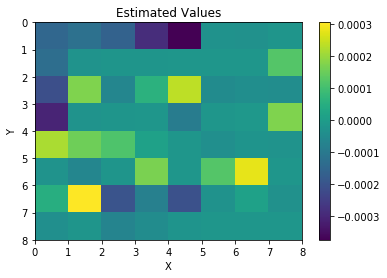

In [35]:
plot_value(TEST_GRID)

In [ ]:
import random
import time

def trainer(epochs=1000, batch_size=40, gamma=0.975, epsilon=1, min_epsilon=0.1, buffer=80):
    
    wins = 0
    losses = 0
    
    # Replay buffers
    actor_replay = []
    critic_replay = []
    
    for i in range(epochs):
        obs = env.reset()
        done = False
        reward = 0
        info = None
        move_counter = 0
        
        while not done:
            state = to_onehot(OBSERVATION_SPACE, obs)
            reward = reward
            value = critic.predict(state.reshape(1, OBSERVATION_SPACE)) # add batch_size dim
            
            # choose next action
            if random.random() < epsilon:
                action = np.random.randint(0, ACTION_SPACE)
            else:
                pi = actor.predict(state.reshape(1, OBSERVATION_SPACE))
                pi /= np.sum(pi)
                print('sum pi =', sum(pi))
                pi = np.cumsum(pi)
                rand = np.random.rand()
                action = np.reshape(np.argwhere(rand<pi))[0]
                
            # take action, observe new state
            new_obs, new_reward, done, info = env.step(action)
            
            new_state = to_onehot(OBSERVATION_SPACE, new_obs)
            new_value = critic.predict(new_state.reshape(1, OBSERVATION_SPACE))
            
            # calc target
            if not done:
                target = reward + gamma * new_value
            else:
                target = reward + gamma * new_reward
                
            # keep the estimated best value in current state
            # in the critic replay
            # if gamma*val > target, is it OK?
            best_value = max(gamma*value, target)
            critic_replay.append([state, best_value])
            
            if done:
                critic_replay.append([new_state, float(new_reward)])
                
            # keep the value advantage in the actor replay
            # if advantage > 0, we encourage the action.
            # or advantage < 0, we discourage the action.
            value_advantage = new_value - value
            actor_replay.append([state, action, value_advantage])
            
            # Trim buffers
            while len(critic_replay) > buffer:
                critic_replay.pop(0)
            while len(actor_replay) > buffer:
                actor_replay.pop(0)
                
            # Critic training!
            if len(critic_replay) >= buffer:
                minibatch = random.sample(critic_replay, batch_size)
                X_train = []
                Y_train = []
                for s, val in minibatch:
                    X_train.append(s) # s.shape = (OBS_SPACE, )
                    Y_train.append(val.reshape((1,))) # originally (1,1)
                X_train = np.array(X_train)
                Y_train = np.array(Y_train)
                critic.fit(X_train, Y_train, batch_size=batch_size, epochs=1, verbose=0)
                
            # Actor training!
            if len(actor_replay) >= buffer:
                minibatch = random.sample(actor_replay, batch_size)
                X_train = []
                Y_train = []
                for s, a, adv in minibatch:
                    X_train.append(s) # s.shape = (OBS_SPACE, )
                    
                    old_Q = actor_model.predict(s.reshape(1, OBSERVATION_SPACE))
                    old_Q = old_Q[0][a] = adv
                    
                    ##　どうやら怪しいため中止
                    
                    
                    Y_train.append(val.reshape((1,))) # originally (1,1)
                X_train = np.array(X_train)
                Y_train = np.array(Y_train)
                critic.fit(X_train, Y_train, batch_size=batch_size, epochs=1, verbose=0)
                
    
                    
                    
                    
            
                
            
                
            
    